In [15]:
# Import All Necessary Lib
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

# Impport Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [16]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
5920
5920
5858
5217
5290
4410


In [17]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


In [19]:
image_size = 160
IMG_SHAPE = (image_size, image_size, 3)

#imports the MobileNetV2 model and discards the last 1000 neuron layer.
base_model=MobileNetV2(input_shape=IMG_SHAPE,weights='imagenet',include_top=False) 
x=base_model.output
x=GlobalAveragePooling2D()(x)
#we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x)
#dense layer 2
x=Dense(1024,activation='relu')(x)
#dense layer 3
x=Dense(512,activation='relu')(x)
#final layer with softmax activation for 7 classes
preds=Dense(7,activation='softmax')(x) 

model=Model(inputs=base_model.input,outputs=preds) #specify the inputs and outputs

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

In [20]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [26]:
train_dir = 'base_dir/train_dir'
validation_dir = 'base_dir/val_dir'

training_images_len = 38569
testing_images_len = 938

batch_size_train = 32
batch_size_validation = 32

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
# Image Already Augmented Previously
train_datagen = ImageDataGenerator(rescale = 1./255. )

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size_train,
                                                    class_mode = 'categorical', 
                                                    target_size = (image_size, image_size))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = batch_size_validation,
                                                          class_mode  = 'categorical', 
                                                          target_size = (image_size, image_size))

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [31]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from tensorflow.keras.optimizers import Adam

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [32]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [33]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

filepath = "model_eksperimen_3.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]



In [36]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = training_images_len/32,
                              epochs = 30,
                              validation_data = validation_generator,
                              validation_steps = testing_images_len/32,
                              class_weight=class_weights,
                              callbacks=callbacks_list)

Epoch 1/30
1206/1205 [==============================] - ETA: -1s - loss: 2.1016 - categorical_accuracy: 0.2505 - top_2_accuracy: 0.4633 - top_3_accuracy: 0.6371
Epoch 00001: val_top_3_accuracy improved from -inf to 0.08529, saving model to model_eksperimen_3.h5
1206/1205 [==============================] - 1701s 1s/step - loss: 2.1016 - categorical_accuracy: 0.2505 - top_2_accuracy: 0.4633 - top_3_accuracy: 0.6371 - val_loss: 2.7112 - val_categorical_accuracy: 0.0416 - val_top_2_accuracy: 0.0533 - val_top_3_accuracy: 0.0853 - lr: 0.0100
Epoch 2/30
1206/1205 [==============================] - ETA: -1s - loss: 2.1112 - categorical_accuracy: 0.2414 - top_2_accuracy: 0.4684 - top_3_accuracy: 0.6480
Epoch 00002: val_top_3_accuracy improved from 0.08529 to 0.91151, saving model to model_eksperimen_3.h5
1206/1205 [==============================] - 1782s 1s/step - loss: 2.1112 - categorical_accuracy: 0.2414 - top_2_accuracy: 0.4684 - top_3_accuracy: 0.6480 - val_loss: 0.9620 - val_categorical_a

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

KeyError: 'accuracy'

In [43]:
print(history)

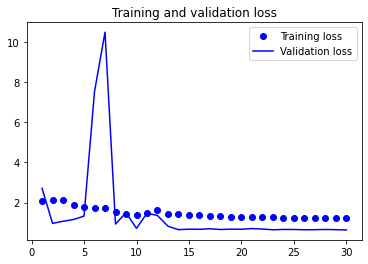

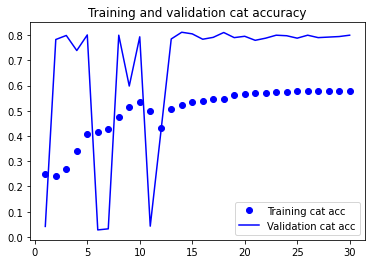

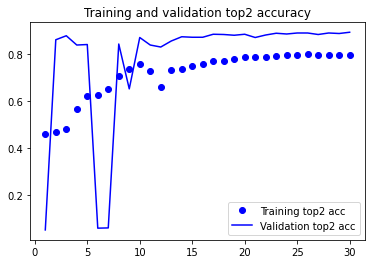

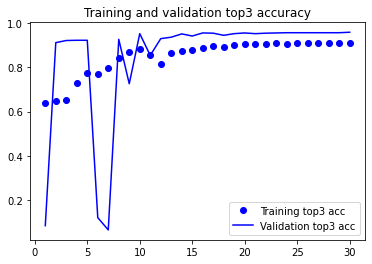

In [44]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()